## Logistic Regression:
In statistics, the **logistic model** (or logit model) is used to model the probability of a certain class or event existing. In this experiment, we are considering the probability of a handwritten character being within 0-9 of Bangla Digits. **Logistic regression** is a statistical model that uses a logistic function to model a binary dependent variable while in its basic form. **Multinomial logistic regression** is a classification method that generalizes logistic regression to multiclass problems, i.e. with more than two possible discrete outcomes.
Mathematically, a multinomial logistic model (like the one we are implementing in the current experiment) has a dependent variable with more than two possible values. Here the dependent variable can have 1 of 10 possible values, which is represented by an indicator variable, where the 10 values are labeled from "0" to "9". Logistic regression gives the probability of a certain input belonging to a class.  The function that converts log-odds to probability is the **logistic function**. Logistic regression is used in various fields, including machine learning. Here, we are using this incredibly useful method to categorize handwritten digits to their appropriate categories.
 


## Numta Database: 
This is a large dataset (85,000+) of Bengali digits which can be used by researchers for benchmarking their algorithm. One of the key topics of NLP is optical character recognition (OCR). To build an OCR in Bengali language, digit classification provides a convenient starting point. For this purpose, this database was built to aid researchers and students alike.


For the given experiment we are to perform the following: Apply only logistic regression for the NumtaDB dataset and build a multiclass classification model that can recognize [0-9] Bengali handwritten digits with different hyperparameter settings.


For this task, we will use the NumtaDB dataset for digit recognition purposes. Hence we will use the training datasets a, c and d for this goal.

In the given experiment, we are using the following fixed hyper-parameters:

- **Input dimension: 784**
  - Size of image: $28 \times 28 = 784$

- **Output dimension: 10**
  - 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

The images in NumtaDB are stored as $28 \times 28$ images. The images are labeled(with the value of the digit in the image) and catalogued in separate csv files, which is what we will use to access the images for the experiment.

**In the following cell, we mounted Google Drive in order to import required files and save the model in the end.**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


**In the following cell, we installed Kaggle in order to be able to use its API in order to directly use datasets from its Numta database.**

In [ ]:
!pip install kaggle

In [ ]:
#upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashnanawarahmed","key":"0b75ee43fb4820370e77d4e2dc4cce51"}'}

**In the following cells, we are importing NumtaDB directly from Kaggle and subsequently unzipping it.**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#changing permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d BengaliAI/numta

100% 1.91G/1.91G [00:24<00:00, 12.3MB/s]
100% 1.91G/1.91G [00:24<00:00, 84.4MB/s]


In [ ]:
from zipfile import ZipFile
file_name='numta.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


**In the following cell, we imported all the required libraries needed to perform logistic regression, plot the data etc.**

In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

Tesla T4


In [ ]:
#load_model = True
load_model = False
if load_model is True:
    model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/NumtaDB/'+ 'bangla_digit_recognizer_logistic.pkl'))
    print('Trained Model Loaded')

In [ ]:
#FUNCTION FOR PRINTING CURRENT TIME
def curr_time():
  now = datetime.now()

  current_time = now.strftime("%H:%M:%S") 
  print("Current Time =", current_time)

**In the following cell, we import the data from the training sets we retrieved from Kaggle in the previous steps. The data is parsed and merged into one dataset from multiple separate csv files..**

In [ ]:
PATH = '/content/'
os.listdir(PATH)
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(PATH + csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

a_csv = showRawTrainingSamples('training-a.csv')
c_csv = showRawTrainingSamples('training-c.csv')
d_csv = showRawTrainingSamples('training-d.csv')
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

a_csv = dropColumns(a_csv)
c_csv = dropColumns(c_csv)
d_csv = dropColumns(d_csv)


total_csv = [a_csv, c_csv, d_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

TRAIN_PATH = 'train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')
print('A Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')



training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-d.csv
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')
         filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]
     filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0
         filename  digit
0      c00000.png      6
1      c



**In the following cell, class Dataset is declared, which converts the data into grayscale range and returns image and label.**

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L') #converting images to grayscale
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

**In the following cell, the data is transformed and converted to Tensor.**

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Training Samples: ",len(train_data))

Training Samples:  54908


## Logistic Regression consists of three steps, which we will now execute one by one, and subsequently repeat for hyper-parameter tuning purposes.

## **Step 1: Designing model using Class**
**In the following cell, we declared the class Logistic Regression Model and implemented init function as well as the forward function that executes the softmax function inside and returns logits and probas.**

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

### In this experiment, we will repeat Steps 2 and 3 for every setting. So we declare Step 1 and execute it before entering into the setting-blocks.

# SETTING 1: Setting a baseline

For a successful experiment in trying to find the best possible combination of hyperparameters for the highest accuracy, we must first set a baseline for the experiment. Initially we consider the following values for the required hyperparameters:


*   Learning Rate: **0.001**
*   Highest number of iterations: **5000**
*   Batch size/mini-batch: **100**
*   Epoch (derived variable): **$iterations \div \frac{totaldata}{minibatch}$**
*   Optimizer: **SGD (Stochastic gradient descent)**

Here, total data being used is **54908**.

We can subsequently change each hyper-parameter one by one in both directions(higher and lower) and finally settle on an optimal combination of parameters.










**In the following cell, dataset is split in a 90:10 ratio for train:test. The data is subsequently loaded into the data loaders. The hyper-parameters are also set to their initial values.**

In [ ]:
learning_rate = 0.001

batch_size=100
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:495
Test dataloader:55


## **Step 2:  Constructing loss and optimizer**
**In the following cell, model is designed using the previously implemented Class. Subsequently the optimizer is declared, which is Step 2. Here, SGD optimizer is being used.**

In [ ]:
#save_model=True
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## **Step 3 : Training: forward, loss, backward, step**
**In the following cell, data is trained, forward pass performed, loss calculated, backward pass perfomed whereby parameters are updated for next iterations. Accuracy is calculated every 500 iterations.**

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
curr_time()
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()

Current Time = 18:00:38
Batch size: 100 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 9
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Iteration: 500. Loss: 2.292854070663452. Accuracy: 12.477231329690346
Epoch: 3
Iteration: 1000. Loss: 2.266955852508545. Accuracy: 15.992714025500911
Epoch: 4
Iteration: 1500. Loss: 2.2698898315429688. Accuracy: 18.415300546448087
Epoch: 5
Iteration: 2000. Loss: 2.2495064735412598. Accuracy: 21.985428051001822
Epoch: 6
Iteration: 2500. Loss: 2.254401445388794. Accuracy: 21.712204007285976
Epoch: 7
Iteration: 3000. Loss: 2.2430264949798584. Accuracy: 23.95264116575592
Epoch: 8
Iteration: 3500. Loss: 2.236318349838257. Accuracy: 26.029143897996356
Epoch: 9
Iteration: 4000. Loss: 2.221064805984497. Accuracy: 29.107468123861565
-----------------------Simulation ends----------------------
Current Time = 

**In the following function, cross entropy loss for the logistic regression is plotted in a graph form for better visualization of data.**

[2.292854070663452, 2.266955852508545, 2.2698898315429688, 2.2495064735412598, 2.254401445388794, 2.2430264949798584, 2.236318349838257, 2.221064805984497]


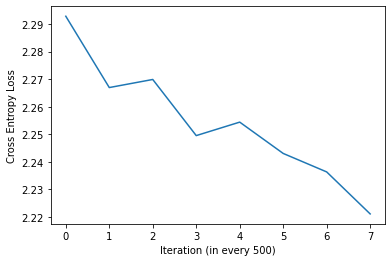

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Here, we can see from the plotted data that the cross entropy loss is not that great. The maximum accuracy achieved is only 29.1%. So we must adjust the hyperparameters in order to achieve better accuracy and possibly more stable perfomance.**

# EXPERIMENTING WITH BATCH SIZE

We first attempt to tune the hyper-parameter **batch-size**. So we will perform 2 experiments. As we have already seen the performance of **batch-size=100**, now we will try the same experiment with 2 other values, which are:
* Batch-size: 200
* Batch-size: 50

Here, 1 value is higher than the baseline value that was used, and 1 value is lower. By this gradual increasing and decreasing process, we can determine which value will be optimal for the hyper-parameter in the subsequent experiments for tuning the other hyperparameters. The values of the other hyper-parameters will remain constant for these 2 experiments:
* Learning-rate: 0.001
* Number of iterations: 5000
* Optimizer: SGD


## SETTING 2: Batch-size=50


In [ ]:
learning_rate = 0.001

batch_size=50
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
#  

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:989
Test dataloader:110


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
curr_time()
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()

Current Time = 18:14:00
Batch size: 50 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 4
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Iteration: 500. Loss: 2.301628351211548. Accuracy: 13.005464480874316
Epoch: 2
Iteration: 1000. Loss: 2.2893073558807373. Accuracy: 14.13479052823315
Iteration: 1500. Loss: 2.2605977058410645. Accuracy: 18.14207650273224
Epoch: 3
Iteration: 2000. Loss: 2.277177572250366. Accuracy: 20.87431693989071
Iteration: 2500. Loss: 2.245680332183838. Accuracy: 22.695810564663024
Epoch: 4
Iteration: 3000. Loss: 2.246464490890503. Accuracy: 26.81238615664845
Iteration: 3500. Loss: 2.2739832401275635. Accuracy: 25.46448087431694
-----------------------Simulation ends----------------------
Current Time = 18:20:27


[2.301628351211548, 2.2893073558807373, 2.2605977058410645, 2.277177572250366, 2.245680332183838, 2.246464490890503, 2.2739832401275635]


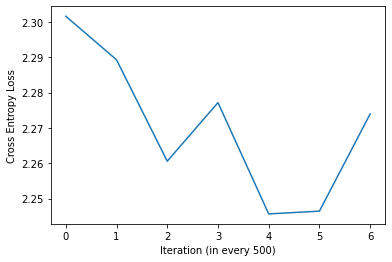

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

## SETTING 3: Batch-size=200


In [ ]:
learning_rate = 0.001

batch_size=200
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1
#num_epochs=int(5)
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
 

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
curr_time()
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()

Current Time = 18:20:27
Batch size: 200 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 18
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.291888475418091. Accuracy: 13.07832422586521
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.2847700119018555. Accuracy: 18.32422586520947
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 2.2720959186553955. Accuracy: 22.422586520947178
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 2.25595760345459. Accuracy: 22.094717668488162
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 2.2577097415924072. Accuracy: 24.18943533697632
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 2.240898847579956. Accuracy: 29.143897996357012
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 2.2202820777893066. Accuracy: 31.548269581056466
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 2.227083444595337. Accuracy: 30.4918032786885

[2.291888475418091, 2.2847700119018555, 2.2720959186553955, 2.25595760345459, 2.2577097415924072, 2.240898847579956, 2.2202820777893066, 2.227083444595337]


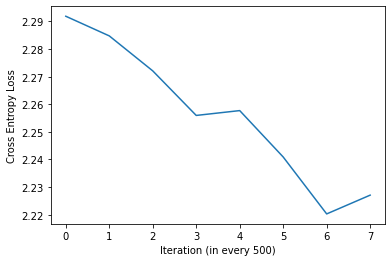

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

## **OBSERVATIONS AFTER EXPERIMENTING WITH BATCH-SIZE:-**


---

Now we can compare the data for the 3 settings (settings 1, 2, 3), where the learning rate, iterations and optimizer were static and only the batch size was varied, in order to determine which batch size we will use moving forward. A table is shown as follows:

|     Criteria     | Batch Size = 100 | Batch Size = 50 | Batch Size = 200 |
| :--------------- | :--------------: | :-------------: | :--------------: |
| Initial Accuracy |      12.47%      |     13.00%      |      13.07%      |
| Highest Accuracy |      29.10%      |     26.81%      |      **31.54%**      |
| Final Accuracy   |      29.10%      |     25.46%      |      **30.49%**      || 

From here if we consider the **highest accuracy (31.54%)** as well as the **maximum growth in accuracy (30.49-13.07)% = 17.42%**, then we must consider **Batch-size = 200** as being the best among the three being brought into consideration. So moving forward in the subsequent experiments, we shall be using this value.

# EXPERIMENTING WITH ITERATIONS:
Now we will attempt to tune the hyper-parameter **iterations**. So we will perform 2 experiments. As we have already seen the performance of **iteration = 5000**, now we will try the same experiment with 2 other values, which are:

* Iterations: 10000

* Iterations: 2500

Here, 1 value is higher than the baseline value that was used, and 1 is lower. By this gradual increasing and decreasing process, we can determine which value will be optimal for the hyper-parameter in the subsequent experiments for tuning the other hyperparameters. The values of the other hyper-parameters will remain constant for these 2 experiments:
* Batch-size: 200
* Learning-rate: 0.001
* Optimizer: SGD

## SETTING 4: Iteration number=2500

In [ ]:
learning_rate = 0.001

batch_size=200
num_iters = 2500
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
 

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
curr_time()
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 16:55:23
Batch size: 200 ; Number of iterations: 2500 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 9
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.2928380966186523. Accuracy: 11.712204007285974
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.2823173999786377. Accuracy: 15.136612021857923
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 2.268326997756958. Accuracy: 17.632058287795992
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 2.265981674194336. Accuracy: 21.34790528233151
-----------------------Simulation ends----------------------
Current Time = 17:08:13


[2.2928380966186523, 2.2823173999786377, 2.268326997756958, 2.265981674194336]


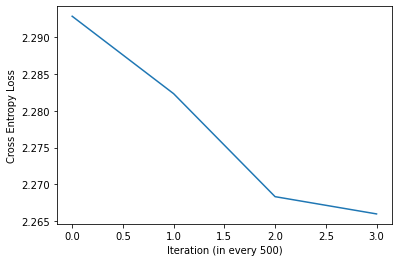

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

## SETTING 5: Iteration number=10000

In [ ]:
learning_rate = 0.001


batch_size=200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
  

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
curr_time()

iteration_loss = []
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 17:08:13
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.2974889278411865. Accuracy: 12.4408014571949
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.2903974056243896. Accuracy: 13.515482695810565
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 2.2776827812194824. Accuracy: 16.903460837887067
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 2.2734525203704834. Accuracy: 21.183970856102004
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 2.268542528152466. Accuracy: 24.043715846994534
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 2.2498841285705566. Accuracy: 26.247723132969035
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 2.2441203594207764. Accuracy: 27.449908925318763
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 2.2188870906829834. Accuracy: 28.8342440

[2.2974889278411865, 2.2903974056243896, 2.2776827812194824, 2.2734525203704834, 2.268542528152466, 2.2498841285705566, 2.2441203594207764, 2.2188870906829834, 2.2251861095428467, 2.2090156078338623, 2.1842403411865234, 2.2008559703826904, 2.2242038249969482, 2.1717658042907715, 2.1793429851531982, 2.17636775970459, 2.177022695541382]


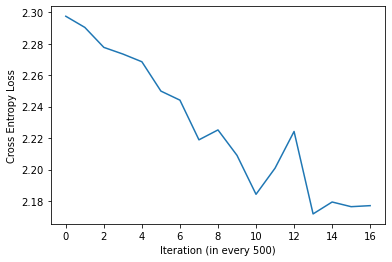

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

## **OBSERVATIONS AFTER EXPERIMENTING WITH ITERATIONS:-**


---

Now we can compare the data for the 3 settings (settings 3, 4, 5), where the learning rate, batch-size and optimizer were static and only the iterations was varied, in order to determine which iterations we will use moving forward. A table is shown as follows:

|     Criteria     | Iterations = 5000 | Iterations = 2500 | Iterations = 10000 |
| :--------------- | :---------------: | :---------------: | :----------------: |
| Initial Accuracy |       11.45%      |      11.71%       |       12.44%       |
| Highest Accuracy |       30.32%      |      21.34%       |       **34.88%**       |
| Final Accuracy   |       30.32%      |      21.34%       |       **33.66%**       || 

From here if we consider the **highest accuracy (34.88%)** as well as the **maximum growth in accuracy (33.66-12.44)% = 21.22%**, then we must consider **Iteration count = 10000** as being the best among the three being brought into consideration. So moving forward in the subsequent experiments, we shall be using this value.

# EXPERIMENTING WITH LEARNING RATE
Now we will attempt to tune the hyper-parameter **learning-rate**. So we will perform 2 experiments. As we have already seen the performance of **learning-rate = 0.001**, now we will try the same experiment with 2 other values, which are:
* Learning-rate: 0.01
* Learning-rate: 0.0001

Here, 1 value is higher than the baseline value that was used (multiplying baseline LR by 10), and 1 is lower (dividing baseline LR by 10). By this gradual increasing and decreasing process, we can determine which value will be optimal for the hyper-parameter in the subsequent experiments for tuning the other hyperparameters. The values of the other hyper-parameters will remain constant for these 2 experiments:
* Batch-size: 200
* Iterations: 10000
* Optimizer: SGD

## SETTING 6: LR=0.01

In [ ]:
learning_rate = 0.01


batch_size=200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
curr_time()

iteration_loss = []
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 15:57:49
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.01 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.203472852706909. Accuracy: 24.08014571948998
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.1201071739196777. Accuracy: 28.67030965391621
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 2.0986907482147217. Accuracy: 33.588342440801455
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 2.0585896968841553. Accuracy: 36.48451730418944
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 2.0308585166931152. Accuracy: 38.21493624772313
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 1.911757230758667. Accuracy: 38.43351548269581
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 1.9793514013290405. Accuracy: 37.85063752276867
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 1.98796808719635. Accuracy: 39.65391621129326


[2.203472852706909, 2.1201071739196777, 2.0986907482147217, 2.0585896968841553, 2.0308585166931152, 1.911757230758667, 1.9793514013290405, 1.98796808719635, 1.936609148979187, 1.9337397813796997, 1.9692964553833008, 1.8976035118103027, 1.971867322921753, 1.9161467552185059, 1.8792386054992676, 1.7959389686584473, 1.9513168334960938]


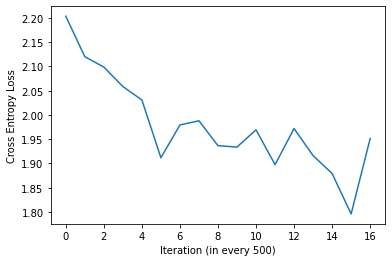

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

## SETTING 7: LR=0.0001

In [ ]:
learning_rate = 0.0001

batch_size=200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10

# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
curr_time()

iteration_loss = []
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 18:49:08
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.0001 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.3018765449523926. Accuracy: 8.979963570127504
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.3027658462524414. Accuracy: 9.890710382513662
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 2.3060948848724365. Accuracy: 10.619307832422587
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 2.301252841949463. Accuracy: 11.256830601092895
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 2.300347089767456. Accuracy: 10.87431693989071
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 2.295670986175537. Accuracy: 11.548269581056466
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 2.297593355178833. Accuracy: 11.857923497267759
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 2.299189805984497. Accuracy: 12.00364298724

[2.3018765449523926, 2.3027658462524414, 2.3060948848724365, 2.301252841949463, 2.300347089767456, 2.295670986175537, 2.297593355178833, 2.299189805984497, 2.291795253753662, 2.288609266281128, 2.2876768112182617, 2.2982044219970703, 2.285449743270874, 2.2858757972717285, 2.2826075553894043, 2.282991886138916, 2.287698268890381]


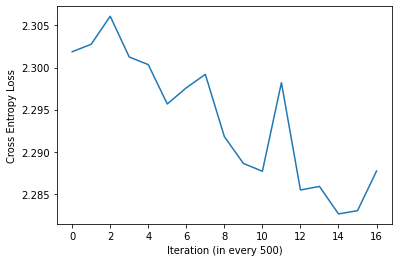

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

## **OBSERVATIONS AFTER EXPERIMENTING WITH LEARNING RATE:-**


---

Now we can compare the data for the 3 settings (setting 5, 6, 7), where the iterations, batch-size and optimizer were static and only the learning rate was varied, in order to determine which learning rate we will use moving forward. A table is shown as follows:

|     Criteria     |  LR = 0.001  |  LR = 0.01  |  LR = 0.0001  |
| :--------------- | :----------: | :---------: | :-----------: |
| Initial Accuracy |    12.44%    |   24.08%    |    8.979%     |
| Highest Accuracy |    34.88%    |   **43.11%**    |    15.04%     |
| Final Accuracy   |    33.66%    |   **42.96%**    |    15.04%     || 

From here if we consider the highest accuracy (43.11%), as well as the highest final accuracy (42.96%) then we must consider **Learning Rate = 0.01** as being the best among the three being brought into consideration. So moving forward in the subsequent experiments, we shall be using this value.

# EXPERIMENTING WITH OPTIMIZERS
Now we will attempt to select an optimizer that performs the best with the 3 chosen hyper-parameters. So we will perform 5 experiments. As we have already seen the performance of **SGD**, now we will try the same experiment with 5 other optimizers, which are:
* Adagrad
* Adam
* ASGD
* RMSprop
* Rprop

The values of the other hyper-parameters will remain constant for these 5 experiments:
* Batch-size: 200
* Iterations: 10000
* Learning Rate: 0.01


## SETTING 8: Optimizer ADAGRAD


In [ ]:
learning_rate = 0.01


batch_size=200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
curr_time()

iteration_loss = []
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 04:23:31
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.01 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.1445634365081787. Accuracy: 27.395264116575593
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.0613770484924316. Accuracy: 34.517304189435336
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 2.0652239322662354. Accuracy: 34.44444444444444
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 2.0855395793914795. Accuracy: 36.90346083788707
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 2.0371572971343994. Accuracy: 39.36247723132969
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 2.0982818603515625. Accuracy: 37.83242258652095
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 2.017423391342163. Accuracy: 39.39890710382514
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 1.9041444063186646. Accuracy: 38.83424408014

[2.1445634365081787, 2.0613770484924316, 2.0652239322662354, 2.0855395793914795, 2.0371572971343994, 2.0982818603515625, 2.017423391342163, 1.9041444063186646, 1.9188820123672485, 1.9182426929473877, 1.9450278282165527, 1.9416426420211792, 1.9243898391723633, 1.7802445888519287, 1.9110342264175415, 1.8798190355300903, 1.9017237424850464]


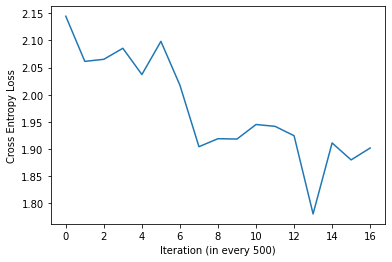

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# SETTING 9: Optimizer ADAM


In [ ]:
learning_rate = 0.01


batch_size=200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
#  

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
curr_time()

iteration_loss = []
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 05:12:32
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.01 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.232707977294922. Accuracy: 27.77777777777778
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.007402181625366. Accuracy: 40.200364298724956
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 1.9027459621429443. Accuracy: 40.60109289617486
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 1.890509009361267. Accuracy: 42.38615664845173
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 1.6812248229980469. Accuracy: 38.01457194899818
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 1.98060941696167. Accuracy: 37.01275045537341
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 1.7628909349441528. Accuracy: 40.32786885245902
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 1.812099814414978. Accuracy: 39.94535519125683
Ep

[2.232707977294922, 2.007402181625366, 1.9027459621429443, 1.890509009361267, 1.6812248229980469, 1.98060941696167, 1.7628909349441528, 1.812099814414978, 1.7967712879180908, 1.9777814149856567, 1.9969432353973389, 1.7320212125778198, 1.658416748046875, 1.7973527908325195, 1.5783265829086304, 1.745145559310913, 1.9369077682495117]


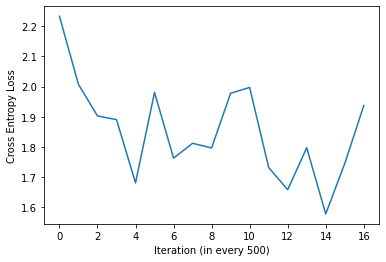

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# SETTING 10: Optimizer ASGD

In [ ]:
learning_rate = 0.01


batch_size=200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
curr_time()

iteration_loss = []
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 06:00:56
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.01 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.225440740585327. Accuracy: 25.846994535519126
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.157231092453003. Accuracy: 31.475409836065573
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 2.0542593002319336. Accuracy: 30.69216757741348
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 2.017385482788086. Accuracy: 32.82331511839708
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 2.066232204437256. Accuracy: 34.31693989071038
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 1.9719990491867065. Accuracy: 38.92531876138433
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 2.0573248863220215. Accuracy: 38.68852459016394
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 2.007331132888794. Accuracy: 39.052823315118395

[2.225440740585327, 2.157231092453003, 2.0542593002319336, 2.017385482788086, 2.066232204437256, 1.9719990491867065, 2.0573248863220215, 2.007331132888794, 1.973544955253601, 1.9038206338882446, 1.9256724119186401, 1.880075216293335, 1.7990431785583496, 1.8806109428405762, 1.9409735202789307, 1.8581141233444214, 1.7891120910644531]


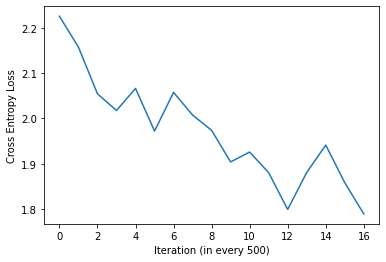

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# SETTING 11: Optimizer RMSProp
Here we use the optimizer RMSprop

In [ ]:
learning_rate = 0.01


batch_size=200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
 

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
curr_time()

iteration_loss = []
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 06:49:22
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.01 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 7.6525349617004395. Accuracy: 20.76502732240437
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 7.298764705657959. Accuracy: 15.519125683060109
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 5.980924606323242. Accuracy: 18.19672131147541
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 5.191455841064453. Accuracy: 24.899817850637522
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 6.787313938140869. Accuracy: 18.08743169398907
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 5.143914699554443. Accuracy: 29.016393442622952
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 5.211954116821289. Accuracy: 20.40072859744991
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 6.054818153381348. Accuracy: 19.398907103825138


[7.6525349617004395, 7.298764705657959, 5.980924606323242, 5.191455841064453, 6.787313938140869, 5.143914699554443, 5.211954116821289, 6.054818153381348, 6.9325032234191895, 4.174516201019287, 5.410264492034912, 5.246894359588623, 4.803093433380127, 5.707354545593262, 4.626723766326904, 4.774820327758789, 4.405472278594971]


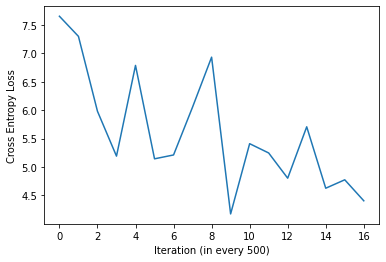

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# SETTING 12: OPTIMIZER Rprop
Here we use the optimizer Rprop

In [ ]:
learning_rate = 0.01


batch_size=200
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10
# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:248
Test dataloader:28


In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
curr_time()

iteration_loss = []
iter = 0
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')

curr_time()

Current Time = 07:38:08
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.01 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.293510675430298. Accuracy: 11.985428051001822
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 2.2801058292388916. Accuracy: 13.406193078324225
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 2.2862579822540283. Accuracy: 13.187613843351548
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 2.2853167057037354. Accuracy: 13.60655737704918
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 2.287198066711426. Accuracy: 12.896174863387978
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 2.281289577484131. Accuracy: 14.043715846994536
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 2.2839913368225098. Accuracy: 15.045537340619308
Epoch: 16
Epoch: 17
Iteration: 4000. Loss: 2.284733295440674. Accuracy: 15.5009107468

[2.293510675430298, 2.2801058292388916, 2.2862579822540283, 2.2853167057037354, 2.287198066711426, 2.281289577484131, 2.2839913368225098, 2.284733295440674, 2.274221420288086, 2.2826240062713623, 2.2786672115325928, 2.2718443870544434, 2.2758777141571045, 2.2709779739379883, 2.2670416831970215, 2.2764644622802734, 2.2647476196289062]


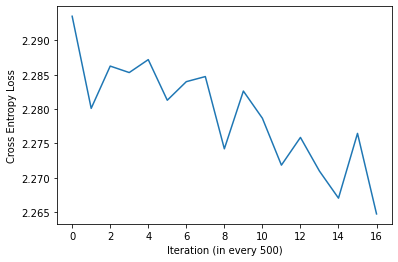

In [ ]:
#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

## **OBSERVATIONS AFTER EXPERIMENTING WITH OPTIMIZERS:-**


---

Now we can compare the data for the 8 settings, where the iterations, batch-size and learning-rate were static and only the Optimizer was varied, in order to determine which optimizer performs the best with the selected hyper-parameters. A table is shown as follows:

|     Criteria     |  SGD  |  ADAGRAD  |  Adam  |  ASGD  |  RMSProp  |  Rprop  |
| :--------------- | :----------: | :---------: | :-----------: | :----------: | :---------: | :-----------: |
| Initial Accuracy |    24.08%    |   27.39%    |    27.77%     |    25.84%    |   20.76%    |    11.98%     |
| Highest Accuracy |    43.11%    |   41.53%    |    **45.48%**     |    43.04%    |   29.92%    |    17.92%     |
| Final Accuracy   |    42.96%    |   40.61%    |    **43.26%**     |    42.93%    |   23.91%    |    17.92%     || 

From here if we consider the highest accuracy(45.48%) as well as the highest final accuracy 43.26%, then we must consider the optimizer **Adam** as being the best optimizer for the chosen hyperparameters.

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/NumtaDB/' + 'bangla_digit_recognizer_logistic.pkl') 
    print('Saved!')

Saved!


# Comparison of results:

---

Here we can see a comparison of all the settings we have implemented in this experiment.

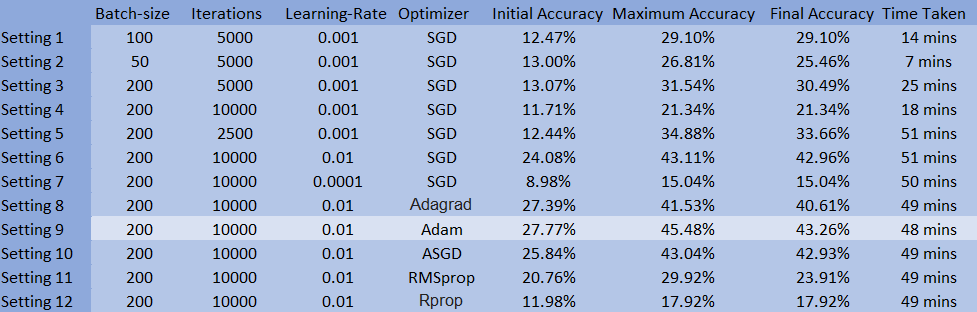

**In conclusion: Adam optimizer used alongside hyper-parameters:- Batch-size=200, iteration=10000, learning rate=0.01 gave the best accuracy among the 12 experiments conducted.**